In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/"

'Task 1 OR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 1 XOR gate with Sigmoid Activation and Squared Error Loss.ipynb'
'Task 1 XOR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 2 work on MNIST data V1.ipynb'
'Task 3.1 Work on MNIST data V2.ipynb'
'Task 3.2 Work on MNIST data V3.ipynb'


In [ ]:
!pwd

/content


In [ ]:
import os
os.chdir('drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/')
!pwd

/content/drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks


In [ ]:
import numpy as np  # import numpy library

In [ ]:
# This is our OR gate data 
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

Y = np.array([
    [0],
    [1],
    [1],
    [1]
])
print(X.shape)
print(Y.shape)

(4, 2)
(4, 1)


In [ ]:
np.unique(Y)

array([0, 1])

In [ ]:
# Converting target to one hot encoding
# One hot encoding 
def one_hot_encoder(data):
    """ One hot encoding function
    Input  : categorical data 
    Output : One hot encoded of given input array
  
    Uses the lowest label byte encoding to make data efficient for training. 
    "int8" which covers from --> Byte (-128 to 127) is sufficient to cover the 
    required labels of 0 and 1 only for one hot encoded result.
    """
    encoded_data = np.zeros((data.shape[0], len(np.unique(data))), dtype='int8') 
    for i,j in enumerate(data):
        encoded_data[i][j] = 1
    return encoded_data
Y_train = one_hot_encoder(Y)
print(Y_train)

[[1 0]
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
Y.dtype

dtype('int64')

In [ ]:
Y_train.dtype

dtype('int8')

In [ ]:
print(X.dtype)
X = X.astype("int8")
print(X.dtype)

int64
int8


In [ ]:
# Setting up training data
X_train = X.T
Y_train = Y_train.T
print(X_train.shape)
print(Y_train.shape)

(2, 4)
(2, 4)


In [ ]:
def initialize_parameters(n_in, n_out, ini_type='plain'):
    """
    Function to initialize some form of random weights and Zero biases
    Args:
        n_in: size of input layer
        n_out: size of output/number of neurons
        ini_type: set initialization type for weights
    Returns:
        params: a dictionary containing W and b
    """

    params = dict()  # initialize empty dictionary of neural net parameters W and b

    if ini_type == 'plain':
        params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    elif ini_type == 'xavier':
        params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))  # set variance of W to 1/n
    elif ini_type == 'he':
        # Good when ReLU used in hidden layers
        params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)  # set variance of W to 2/n

    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params

In [ ]:
## Working on Linear Layer
class LinearLayer:
  def __init__(self, input_shape, n_out, initialization_type='plain'):
    self.m = input_shape[1]
    self.params = initialize_parameters(input_shape[0], n_out, initialization_type)
    self.Z = np.zeros((self.params['W'].shape[0], n_out))

  def forward(self, A_prev):
    """
    A_prev is the data coming from the previous layer, either may be input
    or may be result of activation
    """
    self.A_prev = A_prev
    # performing forward computation W*X + b
    self.Z = np.dot(self.params["W"], A_prev) + self.params["b"]
  
  def backward(self, upstream_grad):
    """
    Computes the back propagation on the linear layer
    """
    # derivative of cost w.r.t. Weights
    self.dW = np.dot(upstream_grad, self.A_prev.T)

    # derivative of cost w.r.t. bias
    self.dB = np.sum(upstream_grad, axis=1, keepdims=True)

    # derivative of cost w.r.t A_prev
    self.dA_prev = np.dot(self.params['W'].T, upstream_grad)
  
  def update_params(self, learning_rate=0.1):
    self.params["W"] = self.params["W"] - learning_rate*self.dW
    self.params["b"] = self.params["b"] - learning_rate*self.dB
  
  def print_initialized(self):
    print("------------------------------------------------------")
    print("Number of training examples : {}".format(self.m))
    # print("Weights : {}".format(self.params["W"]))
    # print("Biases : {}".format(self.params["b"]))
    # print("Resultant matrix Z : {}".format(self.Z))
    print("Weights shape : {}".format(self.params["W"].shape))
    print("Biases : {}".format(self.params["b"].shape))
    print("Resultant matrix Z : {}".format(self.Z.shape))

In [ ]:
test = LinearLayer(input_shape=X_train.shape, n_out=2, initialization_type='plain')
test.print_initialized()
test.forward(X_train)
print("Result after forward pass")
test.print_initialized()

------------------------------------------------------
Number of training examples : 4
Weights shape : (2, 2)
Biases : (2, 1)
Resultant matrix Z : (2, 2)
Result after forward pass
------------------------------------------------------
Number of training examples : 4
Weights shape : (2, 2)
Biases : (2, 1)
Resultant matrix Z : (2, 4)


In [ ]:
class SigmoidLayer:
    """
    This implements activation layers inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)
    
    def print_values(self):
      # print("Activation values {}".format(self.A))
      print("Activation shape {}".format(self.A.shape))

In [ ]:
class SoftmaxLayer:
  """
  This class is used as a activation layer for final layer
  It has sigmoid activation, and its derivative for back-prop
  """
  def __init__(self, shape):
    self.A = np.zeros(shape)
  
  def forward(self, Z):
    self.A = np.exp(Z - np.max(Z, axis=0))  # shift values
    self.A = self.A / np.sum(self.A, axis=0)

  def print_activation(self):
    print("Activation {}".format(self.A))

  def softmax_grad(self, individual_Activations, upstream):
    s = individual_Activations.reshape(-1,1)
    return np.dot(np.diagflat(s) - np.dot(s, s.T), upstream)

  def backward(self, upstream_grad):
    self.dZ = self.A.T
    for i in range(len(self.dZ)):
      self.dZ[i] = self.softmax_grad(self.dZ[i], upstream_grad.T[i])
    self.dZ = self.dZ.T

In [ ]:
Y_train.shape

(2, 4)

In [ ]:
def categorical_crossentropy(Y, Y_hat):
  """
  This function computes the categorical cross entropy cost, and its derivative
  The cost function is optimized for computing cost
  Actual categorical cross entropy loss = -sum(Y_i*log(Yhati))
  However, the computation has been optimized, since the Yi is only 1 at the 
  required target thus loss = -sum(log(Yhat_i_of_j))
  """
  m = Y.shape[1]
  # cost = np.sum([-np.log(j[np.argmax(Y_train, axis=0)[i]]) for i,j in enumerate(Y_hat.T)])/m
  mask = Y_hat*Y_train
  cost = np.sum(-np.log(mask[mask!=0]))/m # removing 0 elements from selection
  dY_hat = (Y_hat - Y)/m# derivative of the cost
  return cost, dY_hat

In [ ]:
np.random.seed(48) # set seed value so that the results are reproduceable
                  # (weights will now be initailzaed to the same pseudo-random numbers, each time)


# Our network architecture has the shape: 
# (input) -> [Linear->Sigmoid] ->(output)  

#------ LAYER-1 ----- define hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=2, initialization_type='xavier')
A1 = SoftmaxLayer(Z1.Z.shape)

In [ ]:
costs = [] # initially empty list, this will store all the costs after a certian number of epochs
# define training constants
learning_rate = 1
number_of_epochs = 5000
# Start training
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)

    
    # ---------------------- Compute Cost ----------------------------
    cost, dA1 = categorical_crossentropy(Y=Y_train, Y_hat=A1.A)
    
    # print and store Costs every 100 iterations.
    if (epoch % 100) == 0:
        print("Cost at epoch#{}: {}".format(epoch, cost))
        costs.append(cost)
    
    # ------------------------- back-prop ----------------------------
    
    A1.backward(dA1)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z1.update_params(learning_rate=learning_rate)

Cost at epoch#0: 0.4072597511385852
Cost at epoch#100: 0.0782813861706412
Cost at epoch#200: 0.05252432164332375
Cost at epoch#300: 0.04174998230111276
Cost at epoch#400: 0.03555306983184875
Cost at epoch#500: 0.03142709767978279
Cost at epoch#600: 0.028436591434708784
Cost at epoch#700: 0.026145232929765557
Cost at epoch#800: 0.02431933686614319
Cost at epoch#900: 0.022821273931984635
Cost at epoch#1000: 0.021564149462060787
Cost at epoch#1100: 0.020490101709417306
Cost at epoch#1200: 0.019558944797580375
Cost at epoch#1300: 0.01874179929074214
Cost at epoch#1400: 0.018017315816651388
Cost at epoch#1500: 0.01736933144739839
Cost at epoch#1600: 0.016785358560117526
Cost at epoch#1700: 0.01625557828632146
Cost at epoch#1800: 0.01577215104119829
Cost at epoch#1900: 0.0153287326104254
Cost at epoch#2000: 0.01492012717062551
Cost at epoch#2100: 0.01454203374067631
Cost at epoch#2200: 0.014190857751627662
Cost at epoch#2300: 0.013863568873238417
Cost at epoch#2400: 0.01355759226506584
Cost 

In [ ]:
def predict(X_train, Y_train):
  m = X_train.shape[1]
  Z1.forward(X_train)
  A1.forward(Z1.Z)
  prediction = np.argmax(A1.A, axis=0)
  print("Prediction results : {}".format(prediction))
  true_label = np.argmax(Y_train, axis=0)
  accuracy = np.sum(prediction==true_label)/m
  print("Accuracy = {}".format(accuracy*100))

In [ ]:
predict(X_train, Y_train)

Prediction results : [0 1 1 1]
Accuracy = 100.0


In [ ]:
def plot_learning_curve(costs, learning_rate, total_epochs, save=False):
    """
    This function plots the Learning Curve of the model

    Args:
        costs: list of costs recorded during training
        learning_rate: the learning rate during training
        total_epochs: number of epochs the model was trained for
        save: bool flag to save the image or not. Default False
    """
    # plot the cost
    import matplotlib.pyplot as plt
    plt.figure()

    steps = int(total_epochs / len(costs))  # the steps at with costs were recorded
    plt.ylabel('Cost')
    plt.xlabel('Iterations ')
    plt.title("Learning rate =" + str(learning_rate))
    plt.plot(np.squeeze(costs))
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1], tuple(np.array(locs[1:-1], dtype='int')*steps))  # change x labels of the plot
    plt.xticks()
    if save:
        plt.savefig('Cost_Curve.png', bbox_inches='tight')
    plt.show()

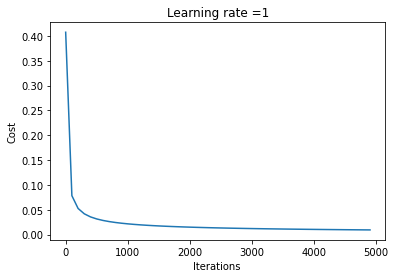

In [ ]:
plot_learning_curve(costs=costs, learning_rate=learning_rate, total_epochs=number_of_epochs)